In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import mean_squared_error
from google.colab import files

np.random.seed(0)

In [ ]:
# Download our data from github
url = 'https://raw.githubusercontent.com/Ryan-P-Mendoza/RNN-Weather-Prediction/main/Dallas%2CTX%201993-01-01%20to%202023-11-27%20-%20Dallas%2CTX%201993-01-01%20to%202023-11-27.csv.csv'
data = pd.read_csv(url)
data = data.ffill()

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
# Assign our input and output columns
X = ["temp", "humidity", "precip" ,"sealevelpressure"]
Y = "tomorrow_temp"

# Scaler fit the data
scaler = StandardScaler()
data[X] = scaler.fit_transform(data[X])

# Calculate the splits for train, validate, and test
total_length = len(data)
trainIndex = int(0.8 * total_length)
validIndex = int(0.9 * total_length)

# Splitting data into train, validate, and test sets
train_data = data.iloc[0:trainIndex]
valid_data = data.iloc[trainIndex:validIndex]
test_data = data.iloc[validIndex:total_length]

# Seperate the inputs and outputs
train_x = np.array([train_data[x].values for x in X]).T
train_y = train_data[Y].values.reshape(train_data.shape[0], 1)

valid_x = np.array([valid_data[x].values for x in X]).T
valid_y = valid_data[Y].values.reshape(valid_data.shape[0], 1)

test_x = np.array([test_data[x].values for x in X]).T
test_y = test_data[Y].values.reshape(test_data.shape[0], 1)


In [ ]:
# Inverse scaler for plotting
data[X] = scaler.inverse_transform(data[X])

# Split visulization
temp_train = np.array(data['temp'][:trainIndex])
temp_validate = np.array(data['temp'][trainIndex:validIndex])
temp_test = np.array(data['temp'][validIndex:])

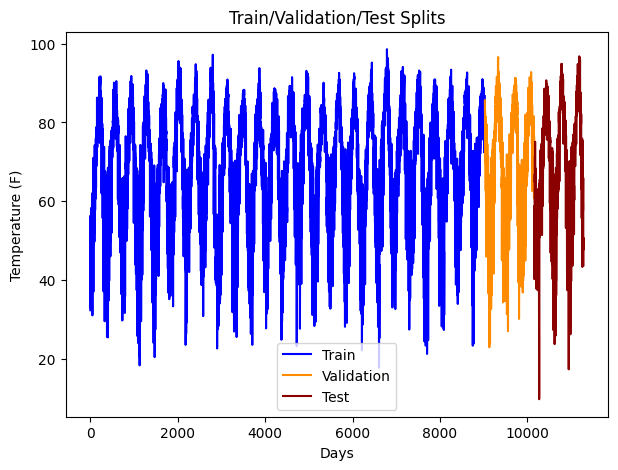

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("Train/Validation/Test Splits")

# Plot training data
plt.plot(np.arange(trainIndex), temp_train, color='blue')

# Plot validation data
plt.plot(np.arange(trainIndex, validIndex), temp_validate, color='darkorange')

# Plot test data
plt.plot(np.arange(validIndex, len(df)), temp_test, color='darkred')

plt.legend(['Train', 'Validation', 'Test'])
plt.ylabel("Temperature (F)")
plt.xlabel("Days")

#plt.savefig('plot.tiff', dpi=300)
plt.show()

#files.download('plot.tiff')

In [ ]:
def initialize(input, hidden, output):
    rnn_layers = []

    # Method for setting weights
    def create_weights(x, y):
        factor = 1 / math.sqrt(y)
        return np.random.rand(x, y) * 2 * factor - factor

    # Initialize weights and biases for the hidden layer
    input_to_hidden_weights = create_weights(input, hidden)
    hidden_to_hidden_weights = create_weights(hidden, hidden)
    hidden_bias = create_weights(1, hidden)

    # Initialize weights and biases for the output layer
    hidden_to_output_weights = create_weights(hidden, output)
    output_bias = create_weights(1, output)

    # Append the initialized weights and biases to the RNN layers
    rnn_layers.append([input_to_hidden_weights, hidden_to_hidden_weights, hidden_bias, hidden_to_output_weights, output_bias])

    return rnn_layers


In [ ]:
def forward_pass(input_data, rnnLayers):
    hidden_states, final_outputs = [], []

    # Loop through all layers from Input -> Hidden(s) -> Output
    for layer in rnnLayers:
        # Start with existing weights and bias for that layer
        input_weights, hidden_weights, hidden_bias, output_weights, output_bias = layer

        # Assign our sample sequence size and dimenstions of the hidden and output layers
        num_samples = input_data.shape[0]
        hidden_dim = input_weights.shape[1]
        output_dim = output_weights.shape[1]

        # Initilize state to all zeros
        layer_hidden_states = np.zeros((num_samples, hidden_dim))
        layer_outputs = np.zeros((num_samples, output_dim))

        # Recurrent computation for hidden states
        for i in range(num_samples):
            # current sequence at that index
            current_input = input_data[i, :]

            # Check if first sequence
            if i > 0:
              # Store previous hidden state
              prev_hidden_state = layer_hidden_states[i - 1]
            else:
              prev_hidden_state = np.zeros(hidden_dim)

            # Activation function to combat exploding gradients
            hidden_state = np.tanh(np.dot(current_input, input_weights) + np.dot(prev_hidden_state, hidden_weights) + hidden_bias)
            layer_hidden_states[i] = hidden_state

            # Calculate output of the current hidden layer
            output = np.dot(hidden_state, output_weights) + output_bias
            layer_outputs[i] = output

        # Update final output of current layer and pass to next layer
        hidden_states.append(layer_hidden_states)
        final_outputs.append(layer_outputs)

    return hidden_states, final_outputs[-1]

In [ ]:
# still need to change this one, has a lot of moving parts and is sensitive to changes (ie: running way slower and not)
def BPTT(rnnLayers, inputs, learning_rate, gradients, hidden_states):
    num_layers = len(rnnLayers)
    num_inputs = inputs.shape[0]
    learning_rate_normalized = learning_rate / num_inputs

    for layer_index in range(num_layers - 1, -1, -1):
        input_weights, hidden_weights, hidden_bias, output_weights, output_bias = rnnLayers[layer_index]
        hidden = hidden_states[layer_index]

        # Initialize gradients
        grad_input_weights = np.zeros_like(input_weights)
        grad_hidden_weights = np.zeros_like(hidden_weights)
        grad_output_weights = np.zeros_like(output_weights)

        # Initialize bias
        grad_hidden_bias = np.zeros_like(hidden_bias)
        grad_output_bias = np.zeros_like(output_bias)

        # Initialize gradient
        next_hidden_gradient = np.zeros(hidden.shape[1])

        # Backward pass
        for t in range(num_inputs - 1, -1, -1):

            # Update all the output layer gradients
            grad_output = gradients[t].reshape(1, -1)
            grad_output_weights += np.matmul(hidden[t].reshape(-1, 1), grad_output)
            grad_output_bias += grad_output

            # Update all the hidden layer gradients
            hidden_gradient = np.matmul(grad_output, output_weights.T)
            if t < num_inputs - 1:
                hidden_gradient += np.matmul(next_hidden_gradient, hidden_weights.T)

            # Apply the derivative of tanh() to update the gradient of the next hidden layer
            tanh_derivative = 1 - hidden[t] ** 2
            hidden_gradient *= tanh_derivative.reshape(1, -1)
            next_hidden_gradient = hidden_gradient

            # Finally update the input layer gradients
            if t > 0:
                grad_hidden_weights += np.matmul(hidden[t-1].reshape(-1, 1), hidden_gradient)
                grad_hidden_bias += hidden_gradient
            grad_input_weights += np.matmul(inputs[t].reshape(-1, 1), hidden_gradient)

        # Update all weights
        input_weights -= grad_input_weights * learning_rate_normalized
        hidden_weights -= grad_hidden_weights * learning_rate_normalized
        output_weights -= grad_output_weights * learning_rate_normalized

        # Update all bias
        hidden_bias -= grad_hidden_bias * learning_rate_normalized
        output_bias -= grad_output_bias * learning_rate_normalized

        # Update RNN layers
        rnnLayers[layer_index] = [input_weights, hidden_weights, hidden_bias, output_weights, output_bias]

    return rnnLayers

In [ ]:
# Define residual function
def residual (predicted, actual):
    return (predicted - actual)

# Calculate the MSE of our model with a data set
def calculate_MSE(X, Y, rnnLayers, sequence_length, error_function):
    predicted_values, actual_values = [], []
    MSE = 0
    for i in range(len(X) - sequence_length):
        # Initialize current sequences
        sequenceX, sequenceY = X[i:i + sequence_length], Y[i:i + sequence_length]

        # Perform our forward pass
        hidden_states, predicted_outputs = forward_pass(sequenceX, rnnLayers)

        # Store predicted values
        predicted_values.append(predicted_outputs[-1].item())  # Assuming outputs is a tensor
        actual_values.append(sequenceY[-1].item())

        # Calculate our MSE of our data set
        MSE += error_function(sequenceY, predicted_outputs)

    # Return MSE
    return MSE / (len(X) - sequence_length), predicted_values, actual_values

# Training loop
def train_epoch(train_data, rnnLayers, learning_rate, sequence_len):
    MSE = 0
    global dict_index
    for i in range(len(train_data[0]) - sequence_len):
        # Initilize current sequences
        sequenceX, sequenceY = train_data[0][i:i + sequence_len], train_data[1][i:i + sequence_len]

        # Perform our forward pass
        hidden_states, predictions = forward_pass(sequenceX, rnnLayers)

        # Perform our back propigation through time (BPTT) to update weights of all layers
        rnnLayers = BPTT(rnnLayers, sequenceX, learning_rate, residual(predictions, sequenceY), hidden_states)

        # Compute MSE of training data
        MSE += mean_squared_error(sequenceY, predictions)
        my_key = str(dict_index)
        MSE_dict[my_key] = MSE / (len(train_data[0]) - sequence_len)
        dict_index = dict_index + 1

    # return our layers with updated weights and our train MSE
    return rnnLayers, MSE / (len(train_data[0]) - sequence_len)

# Evaluation function that runs our validation test with current weights to get MSE
def evaluate_model(validation_data, rnnLayers, sequence_len):
    return calculate_MSE(validation_data[0], validation_data[1], rnnLayers, sequence_len, mean_squared_error)


# Initialize our model variables
epochs = 64
learning_rate = 1e-5
tolerance = 1e-5
rnnLayers = initialize(4,4,1)
pastMSE = 999999999999999999999999
MSE_dict = {}
dict_index = 0

print(f"Number of layers: 3  Neurons: 4, 4, 1  Learning Rate: {learning_rate}  Error Function: MSE")

# Main loop
for epoch in range(epochs):
    # Run our training loop for current epoch
    rnnLayers, trainMSE = train_epoch((train_x, train_y), rnnLayers, learning_rate, 7)

    # Every 5 epochs run a check on our validation set and print current MSE's
    if epoch % 5 == 0:
        validMSE, predicted, actual = evaluate_model((valid_x, valid_y), rnnLayers, 7)
        print(f"Epoch: {epoch}: Training MSE: {trainMSE}, Validation MSE: {validMSE}")

    # Check to see if we hit our tolerence
    if abs(pastMSE - trainMSE) < tolerance:
        print(f"Early stopping at Epoch #: {epoch}, MSE change hit tolerance!")
        break

    # Keep track of previous epochs MSE for tolerence check
    pastMSE = trainMSE

print(f"Epoch: {epoch}: Training MSE: {trainMSE}, Validation MSE: {validMSE}")

Number of layers: 3  Neurons: 4, 4, 1  Learning Rate: 1e-05  Error Function: MSE
Epoch: 0: Training MSE: 3528.660066388834, Validation MSE: 2417.5257720847358
Epoch: 5: Training MSE: 302.85894027233087, Validation MSE: 294.7299311074561
Epoch: 10: Training MSE: 91.91496509597958, Validation MSE: 93.4941558653402
Epoch: 15: Training MSE: 59.18732506504163, Validation MSE: 62.69208317971473
Epoch: 20: Training MSE: 47.28795001711163, Validation MSE: 51.5859760066709
Epoch: 25: Training MSE: 42.0802274961049, Validation MSE: 46.62227110760154
Epoch: 30: Training MSE: 38.843919980388776, Validation MSE: 43.40439174198946
Epoch: 35: Training MSE: 36.07089388247592, Validation MSE: 40.62597744781226
Epoch: 40: Training MSE: 33.46819308148231, Validation MSE: 38.10220750201872
Epoch: 45: Training MSE: 31.4522221077789, Validation MSE: 36.32949538354258
Epoch: 50: Training MSE: 30.333226647049088, Validation MSE: 35.374452221723104
Epoch: 55: Training MSE: 29.88727983378319, Validation MSE: 34

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

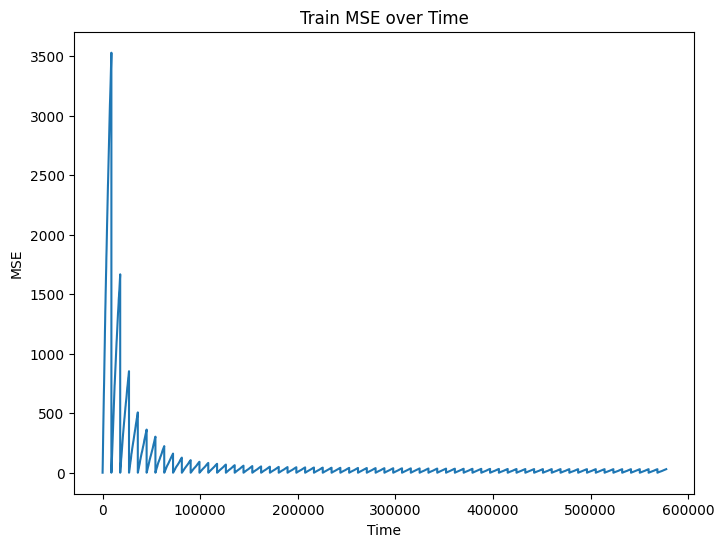

In [ ]:
Y1 = [x for x in MSE_dict.values()]
X1 = [x for x in MSE_dict.keys()]

plt.figure(figsize=(8, 6))
plt.xlabel('Time')
plt.ylabel('MSE')
plt.title('Train MSE over Time')
plt.plot(np.asarray(X1, float),Y1)
plt.savefig('plot.tiff', dpi=300)
files.download('plot.tiff')

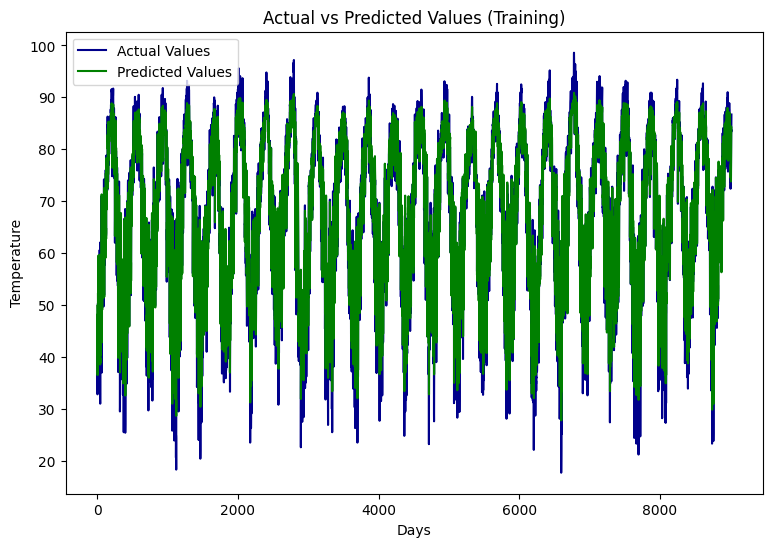

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate Test MSE
trainMSE = 0
trainMSE, predicted_values, actual_values = evaluate_model((train_x, train_y), rnnLayers, 7)

# Plotting Predicted vs Actual Values for Test
plt.figure(figsize=(9, 6))
plt.plot(actual_values, label='Actual Values', color='darkblue')
plt.plot(predicted_values, label='Predicted Values', color='green')
plt.title('Actual vs Predicted Values (Training)')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.savefig('plot.tiff', dpi=300)
plt.show()

files.download('plot.tiff')

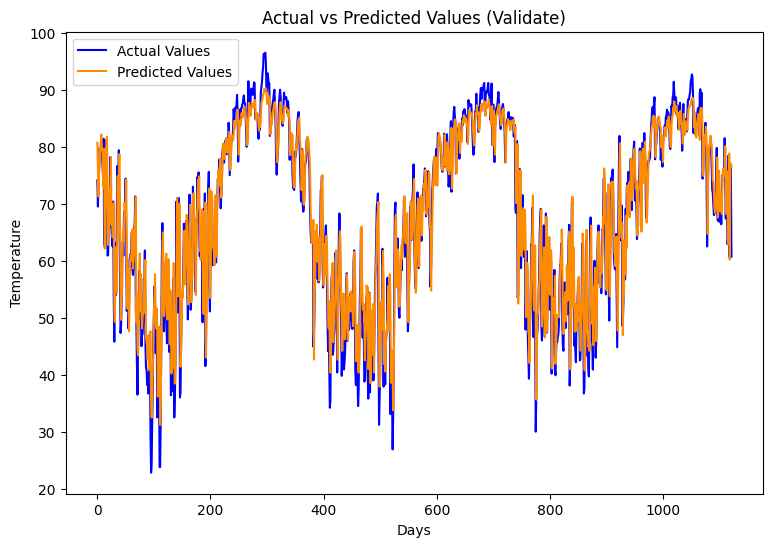

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate Valid MSE
validMSE = 0
validMSE, predicted_values, actual_values = evaluate_model((valid_x, valid_y), rnnLayers, 7)

# Plotting Predicted vs Actual Values for Test
plt.figure(figsize=(9, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='darkorange')
plt.title('Actual vs Predicted Values (Validate)')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.savefig('plot.tiff', dpi=300)
plt.show()

files.download('plot.tiff')

Test MSE: 30.977093176118622



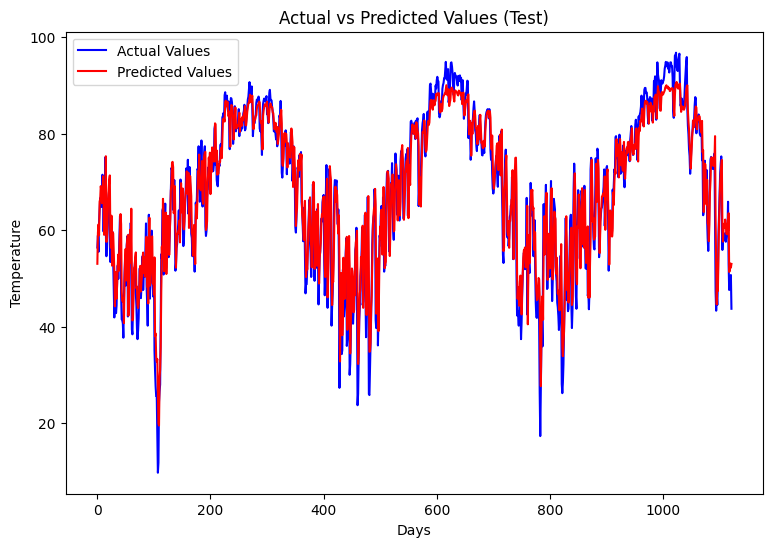

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate Test MSE
testMSE = 0
testMSE, predicted_values, actual_values = evaluate_model((test_x, test_y), rnnLayers, 7)

print(f"Test MSE: {abs(testMSE)}\n")

# Plotting Predicted vs Actual Values for Test
plt.figure(figsize=(9, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values (Test)')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.savefig('plot.tiff', dpi=300)
plt.show()

files.download('plot.tiff')